In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.modeling.models import BlackBody as bb

In [2]:
m_min = 0.1
m_max = 100
T_sun = 5775
alfa = -2.35

wav = np.arange(1000, 10000)*u.AA

b0 = bb(temperature=1000*u.K, scale=1*u.erg/(u.cm**2*u.AA*u.s*u.sr))

def mass_to_time(mass):
    return (mass ** (-2.5))/10  #Gyrs

def salpeter(mass):
    return mass**(alfa)

def mass_to_temperature(mass):
    return mass**0.5

def mass_to_luminosity(mass):
    return mass**3.5

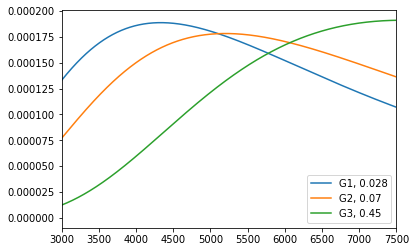

In [3]:
n_bins = 10000
star_pop = np.linspace(m_min, m_max, n_bins)
delta_m = (m_max - m_min)/n_bins
spectrum_normalized = 0

#ages = [0.01, 0.1, 0.3, 0.5, 1, 1.5, 1.75, 2, 4] #Ages in Gyrs
ages = [0.028 , 0.07, 0.45] #Guess on galaxy age in Gyrs -> G1, G2, G3
labels = ['G1', 'G2', 'G3']
for s, ss in zip(ages, labels):
    for i in range(len(star_pop)):
        mass_time = mass_to_time(star_pop[i])
        if(mass_time > s):
            temp = mass_to_temperature(star_pop[i]) * T_sun
            model = bb(temperature=temp*u.K, scale= 1 * u.erg/(u.cm ** 2 * u.AA * u.s * u.sr))
            spectrum = model(wav)
            luminosity_norm = mass_to_luminosity(star_pop[i])
            imf_norm = salpeter(star_pop[i])
            spectrum_normalized += spectrum * luminosity_norm * imf_norm
    label = str(ss) + ', ' + str(s)
    plt.plot(wav, spectrum_normalized/np.sum(spectrum_normalized), label=label)
    spectrum_normalized = 0

plt.xlim(3000, 7500)
plt.legend()
plt.show()
